# Clustering de documents

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1960'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [6]:
# Exemple de fichiers
files[:50]

['KB_JB838_1960-01-10_01-00018.txt',
 'KB_JB838_1960-01-12_01-00011.txt',
 'KB_JB838_1960-01-13_01-00009.txt',
 'KB_JB838_1960-01-21_01-00014.txt',
 'KB_JB838_1960-01-22_01-00015.txt',
 'KB_JB838_1960-01-27_01-00006.txt',
 'KB_JB838_1960-01-28_01-00011.txt',
 'KB_JB838_1960-01-28_01-00021.txt',
 'KB_JB838_1960-01-30_01-00007.txt',
 'KB_JB838_1960-01-31_01-00024.txt',
 'KB_JB838_1960-02-03_01-00019.txt',
 'KB_JB838_1960-02-13_01-00020.txt',
 'KB_JB838_1960-02-19_01-00011.txt',
 'KB_JB838_1960-02-20_01-00006.txt',
 'KB_JB838_1960-02-24_01-00020.txt',
 'KB_JB838_1960-02-26_01-00001.txt',
 'KB_JB838_1960-02-26_01-00011.txt',
 'KB_JB838_1960-03-04_01-00010.txt',
 'KB_JB838_1960-03-06_01-00004.txt',
 'KB_JB838_1960-03-08_01-00008.txt',
 'KB_JB838_1960-03-09_01-00001.txt',
 'KB_JB838_1960-03-11_01-00020.txt',
 'KB_JB838_1960-03-11_01-00022.txt',
 'KB_JB838_1960-03-12_01-00007.txt',
 'KB_JB838_1960-03-13_01-00009.txt',
 'KB_JB838_1960-03-16_01-00007.txt',
 'KB_JB838_1960-03-18_01-00009.txt',
 

In [7]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [8]:
# Exemple de textes
texts[0][:400]

"ia« le som ÏJsIne MéuhMrïiqii S.AT'BBirîï^^ J00, r. Merlu» Duché, Vllvorde ch. STENO-DACTYLO élément de let ordre, bilingue, bon- i ne rémunération. Situation d’avenir, i Candidat, A soumet par écrit 130221H PORTANTE 80C.BRUXELL0I8I cherche pour entrée Immédiate Secrétaire Sténo-Dactylo 3 françalee - 1 an d'expérience, al tuât h «table - semaine de 5 Jours. Ecrire é cur. vit et prêt Ag. Rossel 029"

## Vectoriser les documents à l'aide de TF-IDF

In [9]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [11]:
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\User\Documents\Ma STIC\Ma STIC II\Traitement Automatique de Corpus\2023-2024\TDs\tac\tac_venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Détail de la matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [13]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

rossel        0.429822
ecrire        0.290745
agence        0.287284
bilingue      0.195608
importante    0.172357
                ...   
er            0.000000
erreurs       0.000000
esp           0.000000
espagne       0.000000
♦             0.000000
Length: 2997, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [14]:
cosine([1, 2, 3], [1, 2, 3])

0

In [15]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [16]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [17]:
tfidf_array = tfidf_vectors.toarray()

In [18]:
# Vecteur du document 0
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.        , 0.01046606, ..., 0.01088858, 0.01243841,
       0.        ])

In [20]:
cosine(tfidf_array[0], tfidf_array[1])

0.9628815101868748

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [46]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [47]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [48]:
clusters = km_model.fit_predict(tfidf_vectors)

c:\Users\User\Documents\Ma STIC\Ma STIC II\Traitement Automatique de Corpus\2023-2024\TDs\tac\tac_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [50]:
pprint(dict(clustering))

{0: ['KB_JB838_1960-01-28_01-00021.txt',
     'KB_JB838_1960-01-31_01-00024.txt',
     'KB_JB838_1960-02-24_01-00020.txt',
     'KB_JB838_1960-03-11_01-00022.txt',
     'KB_JB838_1960-04-01_01-00022.txt',
     'KB_JB838_1960-04-06_01-00023.txt',
     'KB_JB838_1960-05-28_01-00021.txt',
     'KB_JB838_1960-08-25_01-00021.txt',
     'KB_JB838_1960-11-16_01-00022.txt',
     'KB_JB838_1961-01-05_01-00016.txt',
     'KB_JB838_1961-01-18_01-00023.txt',
     'KB_JB838_1961-02-11_01-00023.txt',
     'KB_JB838_1961-04-15_01-00020.txt',
     'KB_JB838_1961-04-20_01-00022.txt',
     'KB_JB838_1961-04-29_01-00022.txt',
     'KB_JB838_1961-05-03_01-00024.txt',
     'KB_JB838_1961-05-25_01-00023.txt',
     'KB_JB838_1961-07-18_01-00019.txt',
     'KB_JB838_1961-08-02_01-00017.txt',
     'KB_JB838_1961-09-22_01-00023.txt',
     'KB_JB838_1961-10-29_01-00026.txt',
     'KB_JB838_1961-11-14_01-00020.txt',
     'KB_JB838_1961-11-15_01-00024.txt',
     'KB_JB838_1961-11-29_01-00023.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [51]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [52]:
reduced_vectors[:10]

array([[ 0.49940241, -0.43947916],
       [-0.22882535,  0.00137804],
       [-0.27935516, -0.01590998],
       [ 0.28620178,  0.51679289],
       [ 0.30678363,  0.51829429],
       [-0.28971534, -0.0905384 ],
       [-0.04734939,  0.04053612],
       [-0.06057916,  0.11984372],
       [-0.22345178, -0.05226804],
       [-0.1213846 ,  0.07470422]])

### Générer le plot

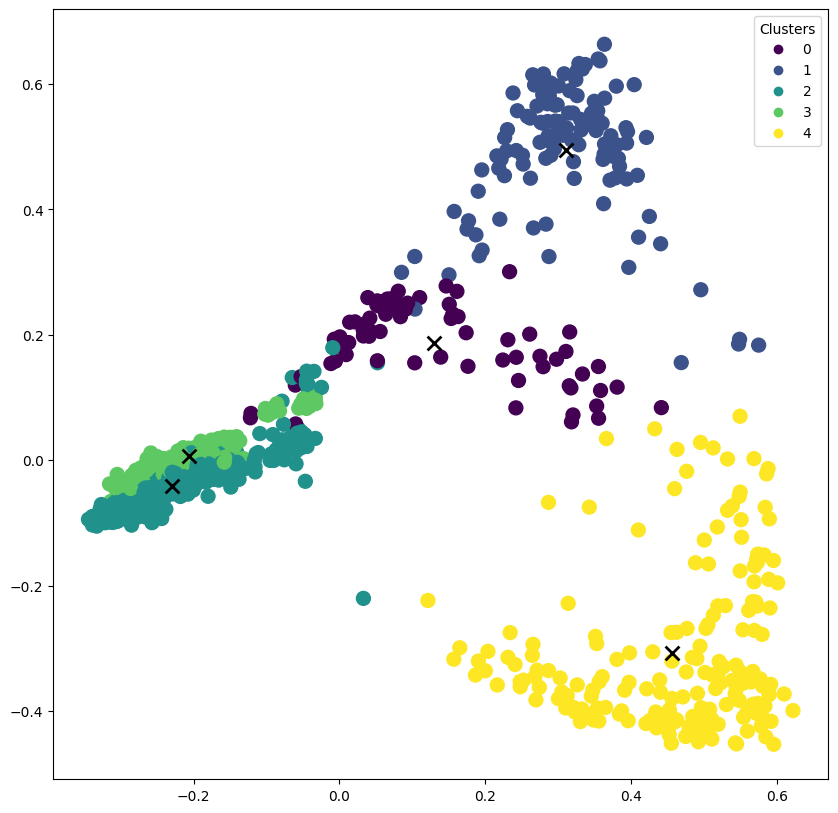

In [53]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")